The idea here is to simulate $500$ trees with $20$ and $200$ taxa and apply `BNPR()` with and without `pc_prior = TRUE`.

In [1]:
## uncomment these lines to install the stuff from my github
# devtools::install_github("maxbiostat/timeTreeSim")
# devtools::install_github("maxbiostat/phylodyn", ref = "pc_prior")
library(timeTreeSim)
library(ggplot2)
library(phylodyn)

In [2]:
nrep <- 500

trees_20taxa <- lapply(1:nrep, function(i){
  timeTreeSim::simuTimeTree(coalmodel = "constant", popSize = 10,
                            taxa_times = seq(1990, 2018, length.out = 20), simu_name = "constant_pop_Ne10_20taxa")  
})

Loading required package: ape


In [4]:
trees_200taxa <- lapply(1:nrep, function(i){
  timeTreeSim::simuTimeTree(coalmodel = "constant", popSize = 10,
                            taxa_times = seq(1990, 2018, length.out = 200), simu_name = "constant_pop_Ne10_20taxa")  
})

In [6]:
system.time(
    reconstructions_20taxa_gamma <- lapply(trees_20taxa, function(x) BNPR(data = x, lengthout = 100))
                                           
)
system.time(    
    reconstructions_20taxa_gumbel <- lapply(trees_20taxa, function(x) BNPR(data = x, lengthout = 100,
                                                                       pc_prior = TRUE))

)

   user  system elapsed 
172.510  57.518 213.158 

   user  system elapsed 
190.056  81.100 256.069 

In [7]:
system.time(
    reconstructions_200taxa_gamma <- lapply(trees_200taxa, function(x) BNPR(data = x, lengthout = 100))
)
system.time(    
    reconstructions_200taxa_gumbel <- lapply(trees_200taxa, function(x) BNPR(data = x, lengthout = 100,
                                                                       pc_prior = TRUE))
)


   user  system elapsed 
189.140 104.654 280.021 

   user  system elapsed 
190.965 120.072 291.600 

We will calculate the percent 

In [18]:
errors_gamma_20taxa <- unlist(lapply(reconstructions_20taxa_gamma,
                                     function(x) 100 * (1/2018)* sum( (x$effpop - 10)/10 ) ))
errors_gumbel_20taxa <- unlist(lapply(reconstructions_20taxa_gumbel,
                                      function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ) )
#
widths_gamma_20taxa <- unlist(lapply(reconstructions_20taxa_gamma,
                                     function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ))
widths_gumbel_20taxa <- unlist(lapply(reconstructions_20taxa_gumbel,
                                      function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ) )
#
errors_gamma_200taxa <- unlist(lapply(reconstructions_200taxa_gamma,
                                      function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ))
errors_gumbel_200taxa <- unlist(lapply(reconstructions_200taxa_gumbel,
                                       function(x) 100 *  (1/2018)* sum( (x$effpop - 10)/10 ) ) )
#
widths_gamma_200taxa <- unlist(lapply(reconstructions_200taxa_gamma,
                                      function(x)  (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ))
widths_gumbel_200taxa <- unlist(lapply(reconstructions_200taxa_gumbel,
                                       function(x) (1/2018)* sum( (x$effpop975 - x$effpop025)/10 ) ) )
#
                                         

errors_dt <- data.frame(
  bias = c(errors_gamma_20taxa, errors_gamma_200taxa, errors_gumbel_20taxa,  errors_gumbel_200taxa),
  widths = c(widths_gamma_20taxa, widths_gamma_200taxa, widths_gumbel_20taxa, widths_gumbel_200taxa),
  ntaxa = rep(c("20", "200"), 2*nrep),
  prior = rep(c("Gamma", "Gumbel"), each = 2*nrep)
)


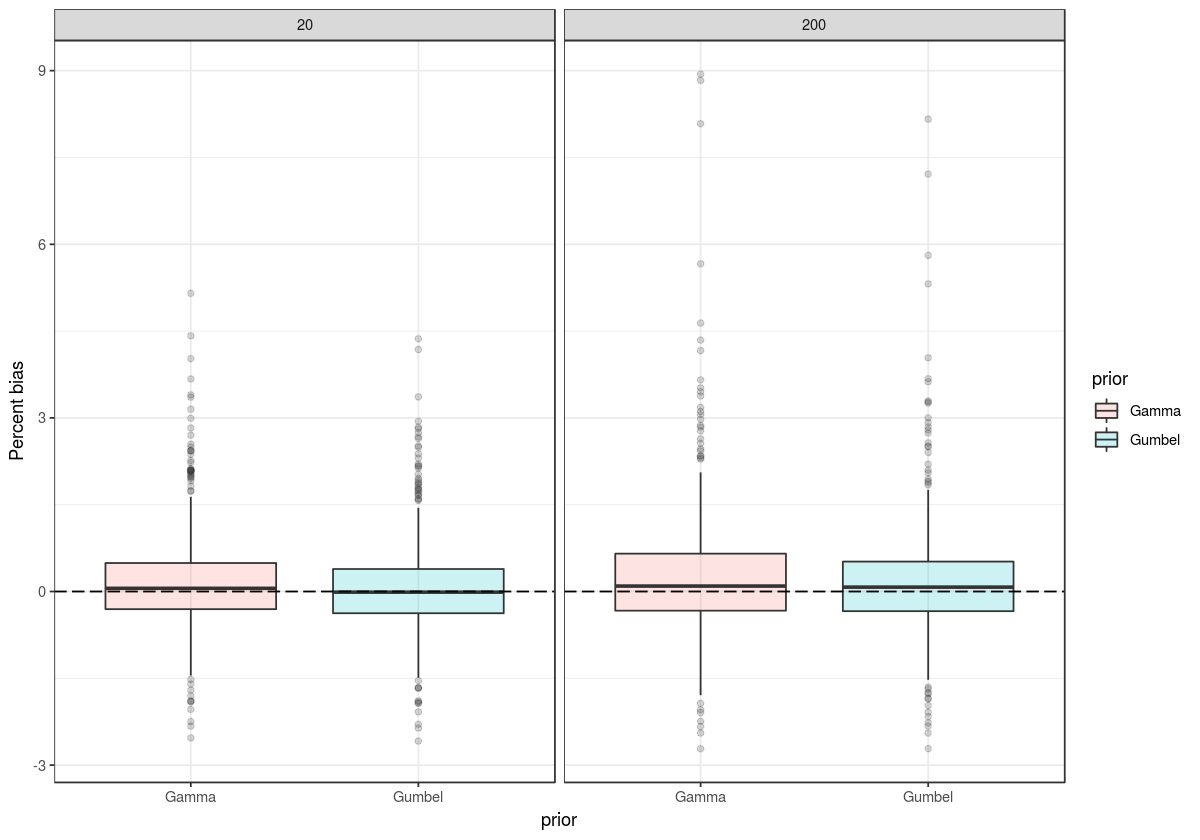

In [73]:
p0 <- ggplot(data = errors_dt, aes(x = prior, y = bias, fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_continuous("Percent bias") + 
  geom_hline(yintercept = 0, linetype = "longdash") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p0

In [74]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/bias_phylodyn.pdf", plot = p0)

Saving 6.67 x 6.67 in image


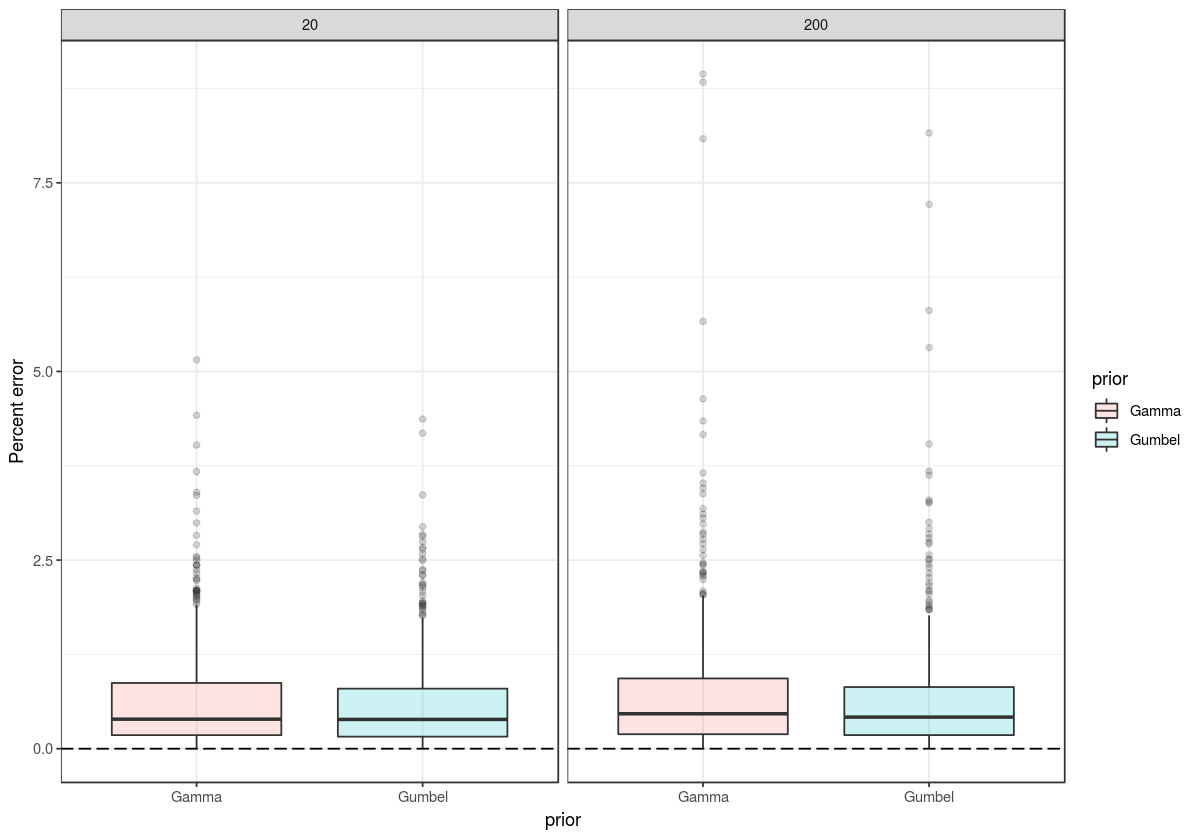

In [75]:
p0b <- ggplot(data = errors_dt, aes(x = prior, y = abs(bias), fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_continuous("Percent error") + 
  geom_hline(yintercept = 0, linetype = "longdash") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p0b

In [78]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/error_phylodyn.pdf", plot = p0b)

Saving 6.67 x 6.67 in image


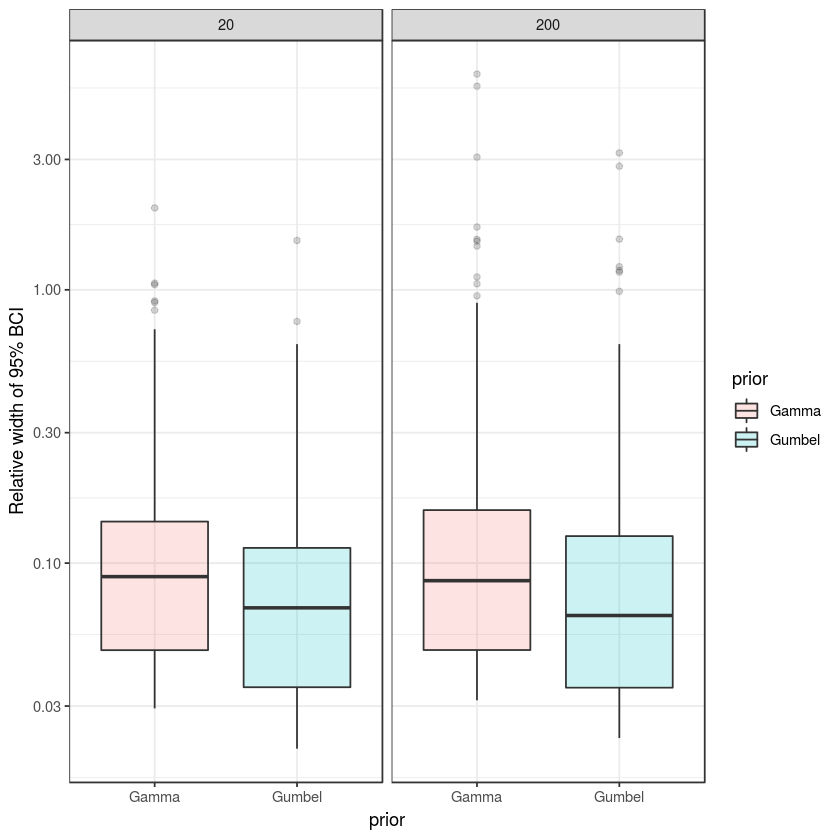

In [21]:
p1 <- ggplot(data = errors_dt, aes(x = prior, y = widths, fill= prior)) + 
  geom_boxplot(alpha = .2) +
  scale_y_log10("Relative width of 95% BCI") +
  facet_grid(.~ ntaxa) +
  theme_bw()
p1

In [22]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/BCI_width_phylodyn.pdf", plot = p1)

Saving 6.67 x 6.67 in image


In [60]:
summaries_gamma <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_20taxa_gamma[[i]]$summary, replicate = i, prior = "Gamma")
} ))
summaries_gumbel <- do.call(rbind, lapply(1:nrep, function(i) {
  data.frame(reconstructions_20taxa_gumbel[[i]]$summary, replicate = i, prior = "Gumbel")
} ))

all_estimates <- rbind(summaries_gamma, summaries_gumbel)
head(all_estimates)

time,mean,sd,quant0.025,quant0.5,quant0.975,replicate,prior
0.2347396,12.24731,7.468753,3.923740,11.86534,46.42519,1,Gamma
0.7042189,12.22898,7.265389,4.045991,11.85168,44.78195,1,Gamma
1.1736981,12.20835,7.055699,4.174620,11.83636,43.14011,1,Gamma
1.6431774,12.18494,6.838974,4.310069,11.81900,41.49699,1,Gamma
2.1126567,12.15511,6.619804,4.444903,11.79713,39.88272,1,Gamma
2.5821359,12.11725,6.397360,4.578082,11.76943,38.28884,1,Gamma


Warning message:
“Removed 16206 rows containing missing values (geom_path).”

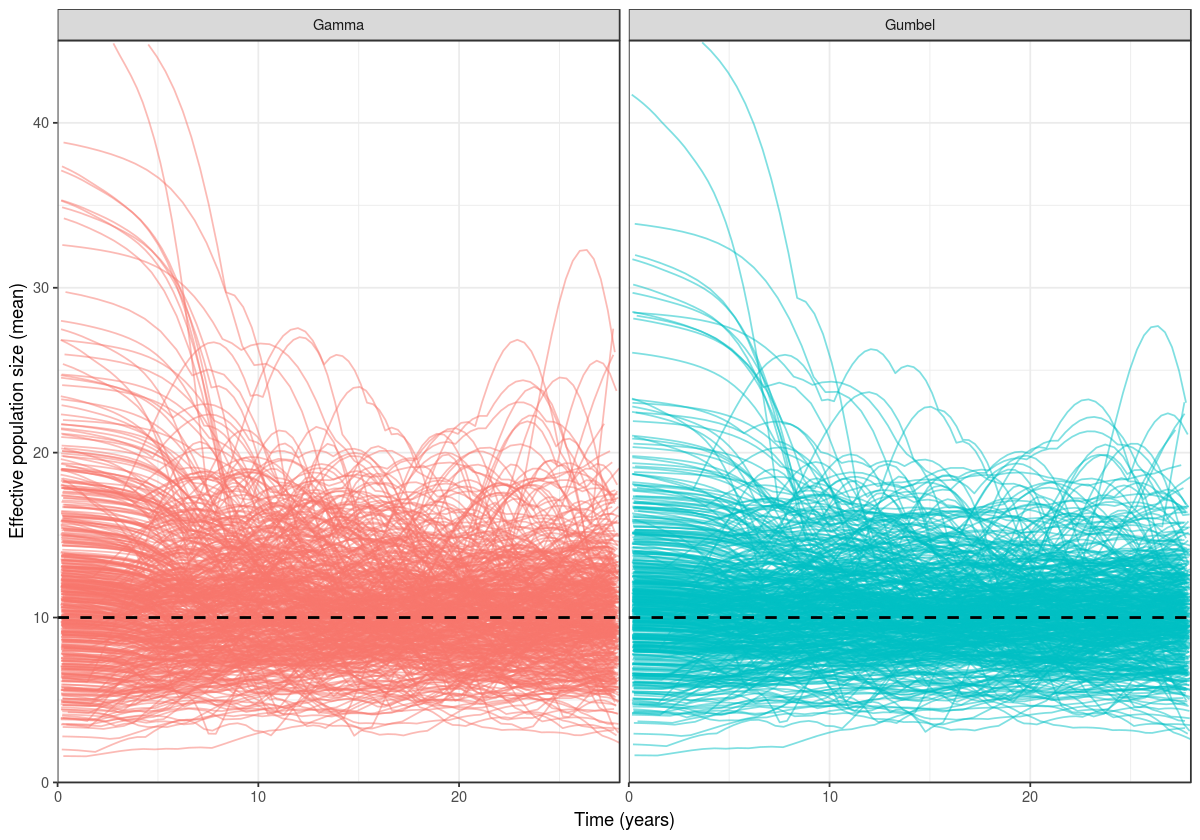

In [88]:
for_plot <- all_estimates
for_plot$replicate <- as.factor(for_plot$replicate)
options(repr.plot.width = 10, repr.plot.height = 7)
p2 <- ggplot(data = for_plot, aes(x = time, y = mean, col = prior, group = replicate)) +  
  scale_x_continuous("Time (years)", expand = c(0, 0), limits = c(0, 28)) +
  scale_y_continuous("Effective population size (mean)", limits = c(0, 45), expand = c(0, 0)) + 
  geom_line(alpha = .5) +
  facet_grid(.~prior) +  
  guides(col = FALSE) + 
  theme_bw() +
  geom_hline(yintercept = 10, linetype = "dashed", size = .8)+
  NULL
p2

In [89]:
ggsave("~/Dropbox/GENERAL_CRAP_TANK/PRIORS_BAYESIAN_PHYLOGENETICS/NOTES/figures/trajectories_mean_phylodyn.pdf",
       plot = p2)

Saving 6.67 x 6.67 in image
Warning message:
“Removed 16206 rows containing missing values (geom_path).”

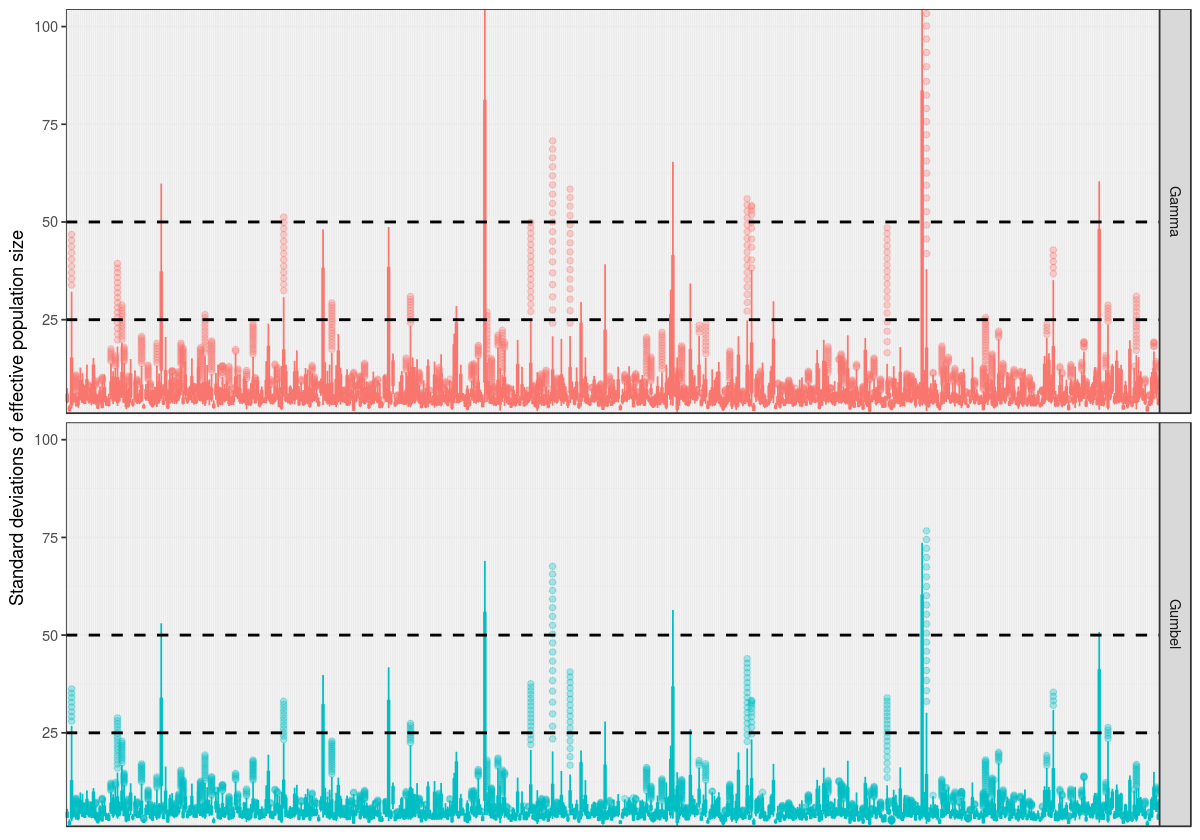

In [86]:
p3 <- ggplot(data = for_plot, aes(x = replicate, y = sd, col = prior)) + 
  geom_boxplot(alpha = .3) +
  scale_y_continuous("Standard deviations of effective population size", expand = c(0, 0)) + 
  facet_grid(prior~.) +
  guides(col = FALSE) + 
  geom_hline(yintercept = 25, linetype = "dashed", size = .8) +
  geom_hline(yintercept = 50, linetype = "dashed", size = .8) +
  theme_bw() +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  NULL
p3

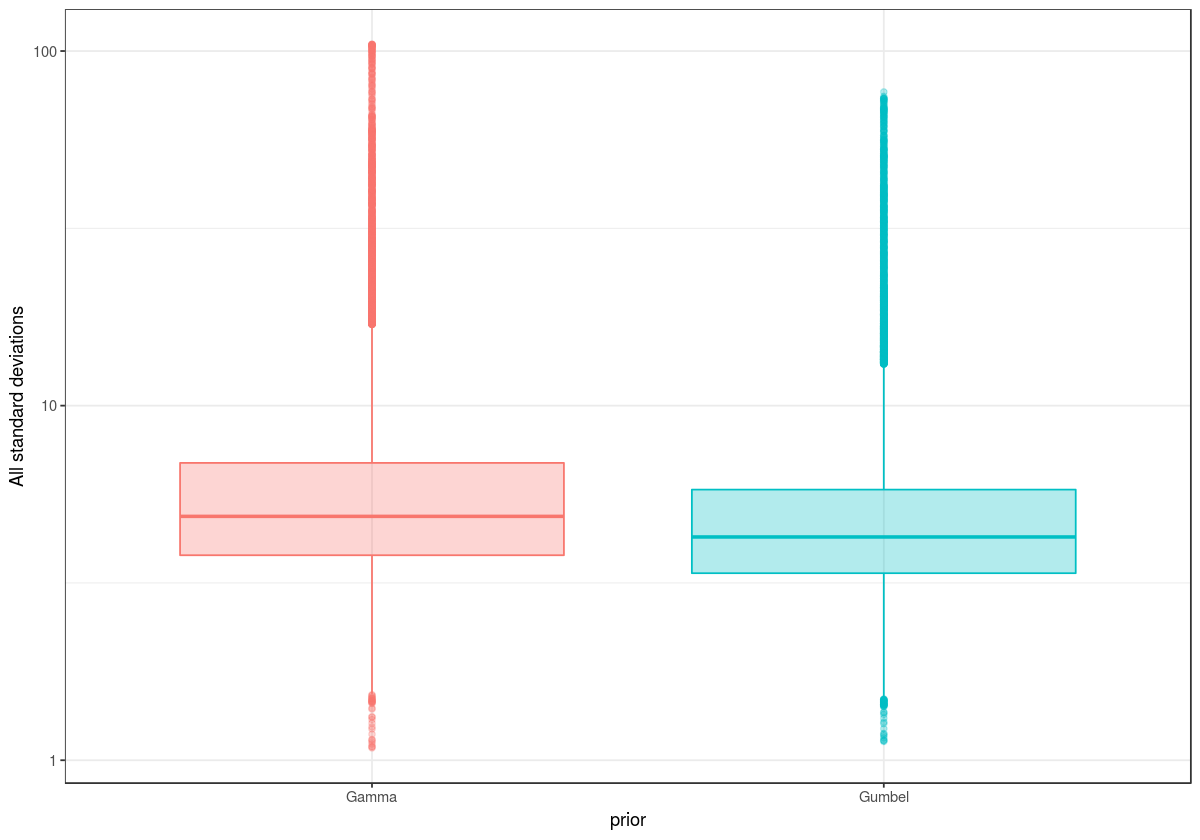

In [72]:
p4 <- ggplot(data = for_plot, aes(x = prior, y = sd, col = prior, fill = prior)) + 
  geom_boxplot(alpha = .3) +
  scale_y_log10("All standard deviations") + 
  guides(col = FALSE) + 
  guides(fill = FALSE) + 
  theme_bw() +
  NULL
p4